## EuroSAT CNN Model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [3]:
# intial transformation for model
transform = transforms.Compose([
    transforms.ToTensor()
])

In [24]:
# data augmentation for model performance

# Training transforms WITH augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # added new transformation: flip
    transforms.RandomCrop(32, padding=4),    # added new transformation: crop
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Test transforms WITHOUT augmentation (keep original)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
from torch.utils.data import random_split
import sys
import os
# Suppress download messages
old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# Downloading and loading full dataset
full_dataset = datasets.EuroSAT(root='./data', 
                                 download=True, 
                                 transform=transform)

sys.stdout = old_stdout

# Split into train/val/test (70/15/15)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Creating data loaders
train_loader = DataLoader(train_dataset, 
                          batch_size=64, 
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=64,
                        shuffle=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=64, 
                         shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 18900
Validation samples: 4050
Test samples: 4050


In [25]:
# Loading with different transforms
train_full = datasets.EuroSAT(root='./data', download=True, transform=train_transform)
val_test_full = datasets.EuroSAT(root='./data', download=True, transform=test_transform)

# Spliting into train_full into train + val
train_size = int(0.824 * len(train_full))  # ~70% of 27000
val_size = len(train_full) - train_size     # ~15%

train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

# Geting test set from val_test_full
test_size = 4050  # 15% of 27000
test_dataset, _ = random_split(val_test_full, [test_size, len(val_test_full) - test_size])

In [26]:
image, label = train_dataset[0] # type: ignore

print(image.size())
print(f"Category label: {label}")

torch.Size([3, 32, 32])
Category label: 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.39607847].


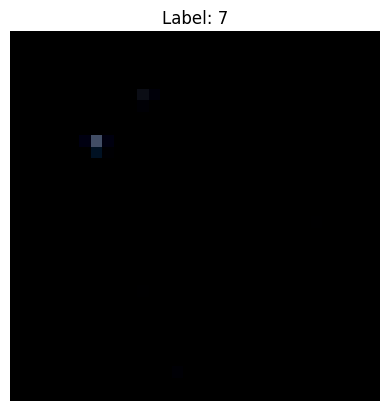

In [27]:
import matplotlib.pyplot as plt

img = image.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [8]:
classes = full_dataset.classes
print(classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [28]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=256 * 4 * 4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

        self.dropout = nn.Dropout(p=0.6)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [29]:
CNN_Model = CNNModel()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_Model.parameters(), lr=0.001)

In [11]:
# Test forward pass to see actual dimension
model = CNNModel()
x = torch.randn(1, 3, 32, 32)
x = model.pool(F.relu(model.conv1(x)))
x = model.pool(F.relu(model.conv2(x)))
x = model.pool(F.relu(model.conv3(x)))
x = model.pool(F.relu(model.conv4(x)))

print(x.shape)  # Will show you the actual dimensions
x = torch.flatten(x, 1)

print(x.shape)  # This is what fc1 should expect

torch.Size([1, 256, 2, 2])
torch.Size([1, 1024])


In [12]:
from torchinfo import summary
summary(CNN_Model, input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 64, 64]           896
├─MaxPool2d: 1-2                         [1, 32, 32, 32]           --
├─Conv2d: 1-3                            [1, 64, 32, 32]           18,496
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Conv2d: 1-5                            [1, 128, 16, 16]          73,856
├─MaxPool2d: 1-6                         [1, 128, 8, 8]            --
├─Conv2d: 1-7                            [1, 256, 8, 8]            295,168
├─MaxPool2d: 1-8                         [1, 256, 4, 4]            --
├─Linear: 1-9                            [1, 512]                  2,097,664
├─Dropout: 1-10                          [1, 512]                  --
├─Linear: 1-11                           [1, 10]                   5,130
Total params: 2,491,210
Trainable params: 2,491,210
Non-train

In [13]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [30]:
print(f"Current device: {next(CNN_Model.parameters()).device}")

device = torch.device('mps')
print(f"Using device: {device}")

CNN_Model = CNN_Model.to(device)
print(f"Current device: {next(CNN_Model.parameters()).device}")

Current device: cpu
Using device: mps
Current device: mps:0


In [31]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Tracing loss
        running_loss += loss.item()
        
        # Calculating accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculating average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
        
    return epoch_loss, epoch_acc

In [32]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track loss
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    return test_loss, test_acc

In [33]:
# Arrays to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# num_epochs = 10 //intial epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_epoch(CNN_Model, train_loader, loss_function, optimizer, device)
    
    # Evaluate on VALIDATION set
    val_loss, val_acc = evaluate(CNN_Model, val_loader, loss_function, device)  # Using val_loader

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)      
    val_accs.append(val_acc)         
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print("-" * 50)

# After loop - final test evaluation
final_test_loss, final_test_acc = evaluate(CNN_Model, test_loader, loss_function, device)
print(f"\nFINAL TEST ACCURACY: {final_test_acc:.2f}%")

Epoch [1/10]
Train Loss: 1.4588, Train Acc: 43.03%
Val Loss: 0.9583, Val Acc: 65.63%
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.8864, Train Acc: 68.30%
Val Loss: 0.7835, Val Acc: 71.01%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.7499, Train Acc: 73.19%
Val Loss: 0.6955, Val Acc: 74.57%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.6517, Train Acc: 76.97%
Val Loss: 0.9357, Val Acc: 66.12%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.5854, Train Acc: 79.54%
Val Loss: 0.6171, Val Acc: 78.20%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.5330, Train Acc: 81.60%
Val Loss: 0.4336, Val Acc: 84.67%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.4679, Train Acc: 83.68%
Val Loss: 0.4820, Val Acc: 82.54%
--------------------------------------------------
Epoch [8/10]
Train Loss: 0.4360, Train Acc: 85.2

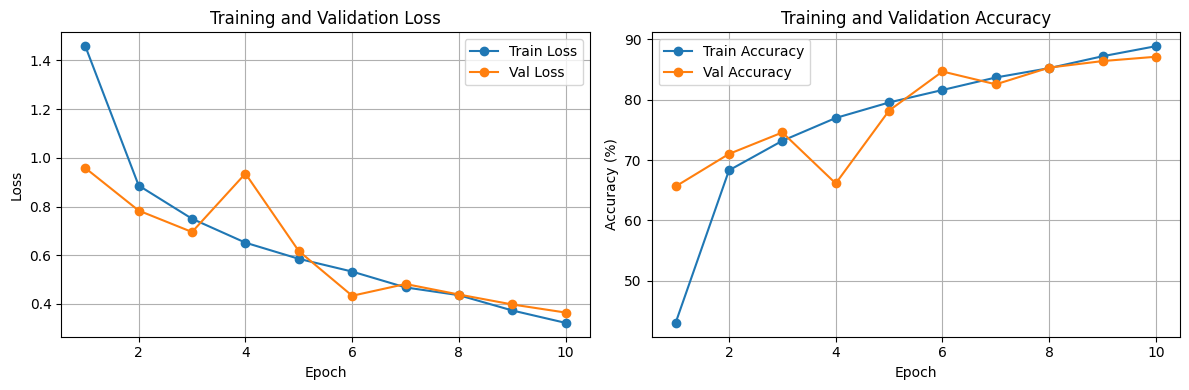

In [34]:
import matplotlib.pyplot as plt

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Loss over epochs
ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, num_epochs+1), val_losses, label='Val Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot 2: Accuracy over epochs
ax2.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy', marker='o')
ax2.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

def get_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return all_preds, all_labels

In [36]:
# Get predictions
test_preds, test_labels = get_predictions(CNN_Model, test_loader, device)

# Classification report
classes = full_dataset.classes
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=classes))


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.90      0.87      0.88       449
              Forest       0.94      0.97      0.96       452
HerbaceousVegetation       0.69      0.94      0.79       435
             Highway       0.82      0.86      0.84       401
          Industrial       0.91      0.97      0.94       387
             Pasture       0.89      0.76      0.82       303
       PermanentCrop       0.85      0.58      0.69       374
         Residential       0.97      0.94      0.96       452
               River       0.91      0.85      0.88       360
             SeaLake       0.98      0.96      0.97       437

            accuracy                           0.88      4050
           macro avg       0.89      0.87      0.87      4050
        weighted avg       0.89      0.88      0.88      4050

